<h1>Gating Experiments: FMO KNN</h1>

In [3]:
from immunova.data.project import Project
from immunova.data.mongo_setup import global_init
from immunova.flow.gating.actions import Template
from tqdm import tqdm_notebook, tqdm
from functools import partial
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
global_init()

In [4]:
peritonitis = Project.objects(project_id='Peritonitis').get()

<h2>Create some populations using the T Panel</h2>

In [5]:
peritonitis.list_fcs_experiments()

['PBMC_T', 'PDMC_T', 'PBMC_M', 'PDMC_M']

In [6]:
pdmc_t = peritonitis.load_experiment('PDMC_T')

In [7]:
t_template = Template(experiment=pdmc_t, sample_id='pd318-01_t')

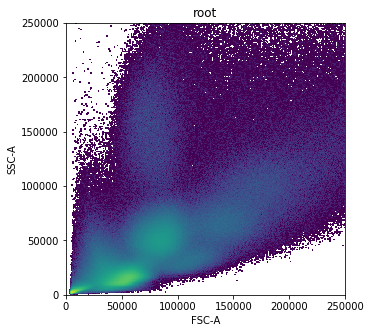

In [8]:
_ = t_template.plot_population('root', x='FSC-A', y='SSC-A')

<h3>Boundary gate</h3>

In [9]:
kwargs=dict(x_min=10000, x_max=125000, y_min=0, y_max=70000)
child_populations = dict(cells=dict(definition='+'))
t_template.create_gate(gate_name='cells', parent='root', x='FSC-A', y='SSC-A', 
                       func='rect_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

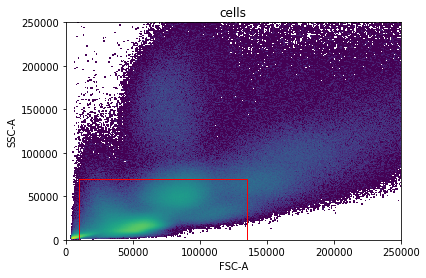

In [10]:
t_template.apply('cells')

<h3>Lymphocyte gate</h3>

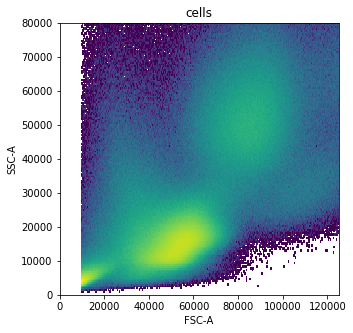

In [11]:
_ = t_template.plot_population('cells', x='FSC-A', y='SSC-A', xlim=(0,125000), ylim=(0,80000))

In [12]:
kwargs=dict(target=(50000,15000), k=4)
child_populations = dict(lymphocytes=dict(definition='+'))
t_template.create_gate(gate_name='lymphocytes', parent='cells',x='FSC-A', 
                       y='SSC-A', func='mm_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

In [ ]:
t_template.apply('lymphocytes')

In [ ]:
t_template.plot_gate('lymphocytes', xlim=(0,125000), ylim=(0,80000))

<h3>Singlet gate</h3>

In [ ]:
_ = t_template.plot_population('lymphocytes', x='FSC-A', y='FSC-H', xlim=(0,125000), ylim=(0,80000))

In [ ]:
kwargs=dict(target=(60000,40000), k=2, conf=0.99)
child_populations = dict(singlets=dict(definition='+'))
t_template.create_gate(gate_name='singlets', parent='lymphocytes', x='FSC-A',
                      y='FSC-H', func='mm_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

In [ ]:
t_template.apply('singlets')

In [ ]:
_ = t_template.plot_gate('singlets', xlim=(0,125000), ylim=(0,80000))

In [ ]:
_ = t_template.plot_population('singlets', x='SSC-W', y='FSC-A', xlim=(55000,135000), ylim=(40000,75000))

In [ ]:
kwargs=dict(q=0.95)
child_populations = dict(singlets_w=dict(definition='+'), doublets=dict(definition='-'))
t_template.create_gate(gate_name='singlets2', parent='singlets', x='SSC-W',
                       func='quantile_gate', func_args=kwargs, gate_type='threshold',
                      child_populations=child_populations)

In [ ]:
t_template.apply('singlets2')

In [1]:
_ = t_template.plot_gate('singlets2', xlim=(50000,150000), ylim=(25000, 80000))

NameError: name 't_template' is not defined

In [ ]:
t_template.gates['singlets2'].to_json()

<h3>Live/Dead Gate</h3>

In [ ]:
_ = t_template.plot_population('singlets2', x='L/D', y='FSC-A')

In [ ]:
kwargs=dict(q=0.99, bool_gate=True, kde_bw=0.1, kde_sample_frac=0.5, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='livedead_gate', children=['live'], parent='singlets2', x='L/D',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

In [ ]:
t_template.apply('livedead_gate')

<h3>T Cells (CD3+)</h3>

In [ ]:
_ = t_template.plot_population('live', x='CD3', y='FSC-A', ylim=(35000,85000))

In [ ]:
kwargs=dict(q=0.95, kde_bw=0.1, kde_sample_frac=1, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='cd3_gate', children=['cd3+'], parent='live', x='CD3',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

In [ ]:
t_template.apply('cd3_gate')

<h3>Gamma Delta T cells</h3>

In [ ]:
_ = t_template.plot_population('cd3+', x='Vd2', y='PanGD')

In [ ]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, expected_populations=[{'id': 'gdt', 'target': (0.9, 0.6)},
                                                                   {'id': 'vd2-', 'target': (0.2, 0.6)},
                                                                   {'id': 'non_gdt', 'target': (0.3, 0.1)}],
            core_only=False)
t_template.create_gate(gate_name='gdt_gate', children=['gdt', 'vd2-', 'non_gdt'], parent='cd3+', x='Vd2',
                       y='PanGD', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

In [ ]:
t_template.apply('gdt_gate')

<h3>MAITs</h3>

In [ ]:
_ = t_template.plot_population('non_gdt', x='Va7.2', y='CD161')

In [ ]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, expected_populations=[{'id': 'mait', 'target': (0.8, 0.6)},
                                                                   {'id': 'classic_tcells', 'target': (0.3, 0.3)}],
            core_only=False, nn=10, sample=0.3)
t_template.create_gate(gate_name='mait_gate', children=['mait', 'classic_tcells'], parent='non_gdt', x='Va7.2',
                       y='CD161', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

In [ ]:
t_template.apply('mait_gate')

<h3>Classic T cells</h3>

In [ ]:
_ = t_template.plot_population('classic_tcells', x='CD4', y='CD8')

In [ ]:
kwargs=dict(min_pop_size=100, distance_nn=0.05, expected_populations=[{'id': 'cd4', 'target': (0.8, 0.3)},
                                                                      {'id': 'cd8', 'target': (0.1, 0.8)}],
            core_only=False, nn=10, sample=0.3)
t_template.create_gate(gate_name='cd4cd8_gate', children=['cd4', 'cd8'], parent='classic_tcells', 
                       x='CD4',y='CD8', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

In [ ]:
t_template.apply('cd4cd8_gate')

In [2]:
t_template.populations.keys()

NameError: name 't_template' is not defined

In [ ]:
data = t_template.data.copy()
data.to_csv('experiment_data/data/pd318_10.csv')

In [ ]:
import pickle
with open('experiment_data/data/pd318_10_pops.pickle', 'wb') as f:
    pickle.dump(t_template.populations, f)

<h2>Iterative KNN gating</h2>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data = pd.read_csv('experiment_data/data/pd318_10.csv')
with open('experiment_data/data/pd318_10_pops.pickle', 'rb') as f:
    populations = pickle.load(f)

<h3>Calculate optimal parameters</h3>

In [ ]:
features = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W',
            'CXCR3', 'CD161', 'CD3', 'CCR7', 'L/D', 'Va7.2', 'CD8', 'Vd2', 'CD45RA',
            'PanGD', 'CD4', 'CD27']

In [ ]:
def grid_search(model, params, calc_weight_scale=None):
    param_tune_results = dict()
    print('=============================================')
    for population_name, pop_data in populations.items():
        if population_name == 'root':
            continue
        print(f'Calculating best parameters for {population_name}')

        #Prep data
        index = pop_data['index']
        parent = pop_data['parent']
        parent_index = populations[parent]['index']
        parent_data = data[data.index.isin(parent_index)]
        pos = parent_data[parent_data.index.isin(index)].index.values
        X = parent_data.copy()
        X['pos'] = 0
        for i in pos:
            X.set_value(i, 'pos', 1)
        Y = X['pos'].values
        X = X[features]
        if calc_weight_scale:
            params[calc_weight_scale].append((X.shape[0]/sum(Y)))
        gs = GridSearchCV(model, params, cv=5, n_jobs=-1)
        gs.fit(X, Y)
        param_tune_results[population_name] = gs.cv_results_
    print('=============================================')
    return param_tune_results

In [ ]:
xgb = XGB()
params = dict(eta=[0.01, 0.1, 0.15, 0.2, 0.3], gamma=[0, 3, 6, 9], min_child_weight=[1,5,10,15],
                 subsample=[0.5, 1], scale_pos_weight = [1],
                 predictor=['gpu_predictor'], max_depth=[2,4,6,8])
xgb_results = grid_search(xgb, params, calc_weight_scale='scale_pos_weight')

In [ ]:
svm = SVC(class_weight='balanced', cache_size=1000)
params = dict(kernel=['linear', 'poly', 'rbf', 'sigmoid'], gamma=['auto', 'scale'])
svm_results = grid_search(svm, params)

In [ ]:
lr = LogisticRegression()
params = dict(penalty=['l2', 'elasticnet'], class_weight=['balanced', None], random_state=[42])
xgb_results = grid_search(xgb, params)